## Import Libraries

In [ ]:
# Standard library
import os

# Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bars
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# NLP / text representation
from gensim.models import FastText

# Models
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

# Scikit-learn utilities
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    StratifiedKFold,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    f1_score,
)

from scipy.stats import randint, uniform, loguniform


c:\Users\Austin\anaconda3\envs\XGB\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import and Subset Data

In [2]:
data = pd.read_csv("Data/GamesDataClean.csv", usecols=["content", "score", "game_name"])
data = data.dropna()
subset = (
    data.groupby("game_name", group_keys=False)
        .apply(lambda x: x.sample(n=min(50, len(x)), random_state=42))
        .reset_index(drop=True)
)
subset.to_csv("Data/GamesDataClean_Subset50.csv", index=False)
subset

C:\Users\Austin\AppData\Local\Temp\ipykernel_7844\296425821.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(50, len(x)), random_state=42))


,game_name,content,score
0,8 Ball Pool,enjoy selection 8 ball video pool excite,5
1,8 Ball Pool,miniclip id miniclip account lose remember pas...,5
2,8 Ball Pool,graphic pair people extremely high level reall...,3
3,8 Ball Pool,thumb mediumlight skin tone web suck go line c...,1
4,8 Ball Pool,one ad make hang unresponsive annoy hope team ...,2
...,...,...,...
995,Shadow Fight 2,think need recharge energy ad fight make,3
996,Shadow Fight 2,need energy bar wait refill yhe person hoo mak...,1
997,Shadow Fight 2,think well compare l,5
998,Shadow Fight 2,love especially music sparkle heart,4


## Split X&Y, Train&Test

In [3]:
X = subset["content"].values
y = subset["score"].astype(int).values

In [4]:
FastTextContent = []
for text in X:
    FastTextContent.append(text.split())

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_FT, X_test_FT, y_train_FT, y_test_FT = train_test_split(FastTextContent, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
if y_train.min() == 1:
    y_train = y_train - 1
    y_test  = y_test  - 1
    y_train_FT = y_train_FT - 1
    y_test_FT  = y_test_FT  - 1

## Fast Text

### For LogReg&XGB

In [7]:
model_ft = FastText(
    sentences=X_train_FT,
    vector_size=300,
    window=5,
    min_count=5,
    sg=1,
    workers=os.cpu_count(),
    epochs=10
)
ft = model_ft.wv

def avg_vector(tokens, model):
    words = [w for w in tokens if w in model.wv]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[w] for w in words], axis=0)

X_train_avg = np.array([avg_vector(t, model_ft) for t in X_train_FT])
X_test_avg = np.array([avg_vector(t, model_ft) for t in X_test_FT])

### For BiLSTM

In [8]:
# --- Parameters ---
max_len = 200          
embed_dim = model_ft.vector_size 

# --- Word to vector sequence ---
def tokens_to_vectors(tokens, model, max_len):
    seq = []
    for w in tokens:
        if w in model.wv:
            seq.append(model.wv[w])
        else:
            seq.append(np.zeros(embed_dim))  # handle OOV
        if len(seq) >= max_len:
            break
    # pad to max_len
    if len(seq) < max_len:
        seq += [np.zeros(embed_dim)] * (max_len - len(seq))
    return np.array(seq)

X_train_seq = np.array([tokens_to_vectors(t, model_ft, max_len) for t in X_train_FT])
X_test_seq  = np.array([tokens_to_vectors(t, model_ft, max_len) for t in X_test_FT])

print("Train shape:", X_train_seq.shape)
print("Test shape :", X_test_seq.shape)

Train shape: (800, 200, 300)
Test shape : (200, 200, 300)


## Fine Tuned Logistic Regression

### TF-IDF + LogReg

In [ ]:
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=10000,
        stop_words="english",
        ngram_range=(1,2)
    )),
    ("clf", LogisticRegression(
        max_iter=3000, multi_class="multinomial", solver="lbfgs", n_jobs=-1
    ))
])

param_dist = {
    "clf__C": loguniform(1e-3, 1e2),
    "clf__class_weight": [None, "balanced"],
    "clf__solver": ["lbfgs", "saga"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search_TF_LR = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=20,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

# 4) Fit & evaluasi
n_iter = 20
with tqdm_joblib(tqdm(total=n_iter * 5, desc="RandomizedSearch (5-fold)")):
    search_TF_LR.fit(X_train, y_train)
best_TF_LR = search_TF_LR.best_estimator_
pred_TF_LR_ft = best_TF_LR.predict(X_test)

RandomizedSearch (5-fold):   0%|          | 0/250 [00:00<?, ?it/s]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Austin\anaconda3\envs\XGB\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
 40%|████      | 101/250 [00:04<00:06, 23.59it/s]


### FastText + LogReg

In [ ]:
pipe_ft_lr = Pipeline([
    ("scaler", StandardScaler(with_mean=True)),
    ("clf", LogisticRegression(
        max_iter=3000, multi_class="multinomial", solver="lbfgs", n_jobs=-1
    ))
])

param_dist_ft = {
    "clf__C": loguniform(1e-3, 1e+2),
    "clf__class_weight": [None, "balanced"],
    "clf__solver": ["lbfgs", "saga"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search_FT_LR = RandomizedSearchCV(
    pipe_ft_lr,
    param_distributions=param_dist_ft,
    n_iter=20,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

n_iter = 20
with tqdm_joblib(tqdm(total=n_iter * 5, desc="RandomizedSearch (5-fold)")):
    search_FT_LR.fit(X_train_avg, y_train)
best_FT_LR = search_FT_LR.best_estimator_
pred_FT_LR_ft = best_FT_LR.predict(X_test_avg)

Fitting 5 folds for each of 20 candidates, totalling 100 fits



























c:\Users\Austin\anaconda3\envs\XGB\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(

 40%|████      | 101/250 [00:38<00:57,  2.59it/s]


## Fine Tuned XGBoost Model

### TF-IDF + XGBoost

In [ ]:
num_class = len(np.unique(y_train))

# 1) Pipeline: TF-IDF -> XGBoost
pipe_xgb = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=10000,
        stop_words="english",
        ngram_range=(1, 2),
        sublinear_tf=True
    )),
    ("clf", xgb.XGBClassifier(
        objective="multi:softprob",
        num_class=num_class,
        tree_method="hist",
        n_jobs=-1,
        random_state=42,
        eval_metric="mlogloss"
    ))
])

# 2) Hyperparameter space (XGBoost only)
param_dist_xgb = {
    "clf__n_estimators": randint(300, 1500),
    "clf__learning_rate": loguniform(1e-3, 3e-1),
    "clf__max_depth": randint(4, 12),
    "clf__min_child_weight": randint(1, 8),
    "clf__subsample": uniform(0.6, 0.4),         # 0.6–1.0
    "clf__colsample_bytree": uniform(0.6, 0.4),  # 0.6–1.0
    "clf__gamma": uniform(0.0, 2.0),
    "clf__reg_alpha": loguniform(1e-8, 1e-1),
    "clf__reg_lambda": loguniform(1e-3, 1e+1),
}

# 3) CV + randomized search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search_TF_XGB = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=param_dist_xgb,
    n_iter=20,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-10,
    verbose=1,
    random_state=42,
)

# 4) Fit & evaluate
n_iter = 20
with tqdm_joblib(tqdm(total=n_iter * 5, desc="RandomizedSearch (5-fold)")):
    search_TF_XGB.fit(X_train, y_train)
best_TF_XGB = search_TF_XGB.best_estimator_
pred_TF_XGB_ft = best_TF_XGB.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
































































































































































































 40%|████      | 100/250 [06:41<10:01,  4.01s/it]


### FastText + XGBoost

In [ ]:
# Make sure they are float32 (faster, less RAM)
X_train_avg = np.asarray(X_train_avg, dtype=np.float32)
X_test_avg = np.asarray(X_test_avg,  dtype=np.float32)
num_class = len(np.unique(y_train))

# 1) Base XGBoost model (no scaler needed for trees)
base_xgb = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=num_class,
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
    eval_metric="mlogloss"
)

# 2) Hyperparameter space
param_dist_ft_xgb = {
    "n_estimators": randint(300, 1500),
    "learning_rate": loguniform(1e-3, 3e-1),
    "max_depth": randint(4, 12),
    "min_child_weight": randint(1, 8),
    "subsample": uniform(0.6, 0.4),         # 0.6–1.0
    "colsample_bytree": uniform(0.6, 0.4),  # 0.6–1.0
    "gamma": uniform(0.0, 2.0),
    "reg_alpha": loguniform(1e-8, 1e-1),
    "reg_lambda": loguniform(1e-3, 1e+1),
}

# 3) CV + randomized search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search_FT_XGB = RandomizedSearchCV(
    estimator=base_xgb,
    param_distributions=param_dist_ft_xgb,
    n_iter=20,
    scoring="f1_macro",
    cv=cv,
    n_jobs=10,
    verbose=2,
    random_state=42,
)

n_iter = 20
with tqdm_joblib(tqdm(total=n_iter * 5, desc="RandomizedSearch (5-fold)")):
    search_FT_XGB.fit(X_train_avg, y_train)
best_FT_XGB = search_FT_XGB.best_estimator_
pred_FT_XGB_ft = best_FT_XGB.predict(X_test_avg)

Fitting 5 folds for each of 20 candidates, totalling 100 fits






































































































































































































 40%|████      | 100/250 [12:02<18:03,  7.22s/it]


In [13]:
results = {
    "Model": [
        "TF-IDF + Logistic Regression",
        "TF-IDF + XGBoost",
        "FastText (avg) + Logistic Regression",
        "FastText (avg) + XGBoost",
    ],
    "Accuracy": [
        accuracy_score(y_test, pred_TF_LR_ft),
        accuracy_score(y_test, pred_TF_XGB_ft),
        accuracy_score(y_test_FT, pred_FT_LR_ft),
        accuracy_score(y_test_FT, pred_FT_XGB_ft),
    ],
    "Macro-F1": [
        f1_score(y_test, pred_TF_LR_ft, average="macro"),
        f1_score(y_test, pred_TF_XGB_ft, average="macro"),
        f1_score(y_test_FT, pred_FT_LR_ft, average="macro"),
        f1_score(y_test_FT, pred_FT_XGB_ft, average="macro"),
    ],
    "Weighted-F1": [
        f1_score(y_test, pred_TF_LR_ft, average="weighted"),
        f1_score(y_test, pred_TF_XGB_ft, average="weighted"),
        f1_score(y_test_FT, pred_FT_LR_ft, average="weighted"),
        f1_score(y_test_FT, pred_FT_XGB_ft, average="weighted"),
    ]
}

df_results = pd.DataFrame(results)
df_results.round(4)

,Model,Accuracy,Macro-F1,Weighted-F1
0,TF-IDF + Logistic Regression,0.480,0.3246,0.4720
1,TF-IDF + XGBoost,0.490,0.2731,0.4317
2,FastText (avg) + Logistic Regression,0.385,0.2953,0.3999
3,FastText (avg) + XGBoost,0.480,0.2852,0.4312


RandomizedSearch (5-fold):   0%|          | 0/250 [12:28<?, ?it/s]


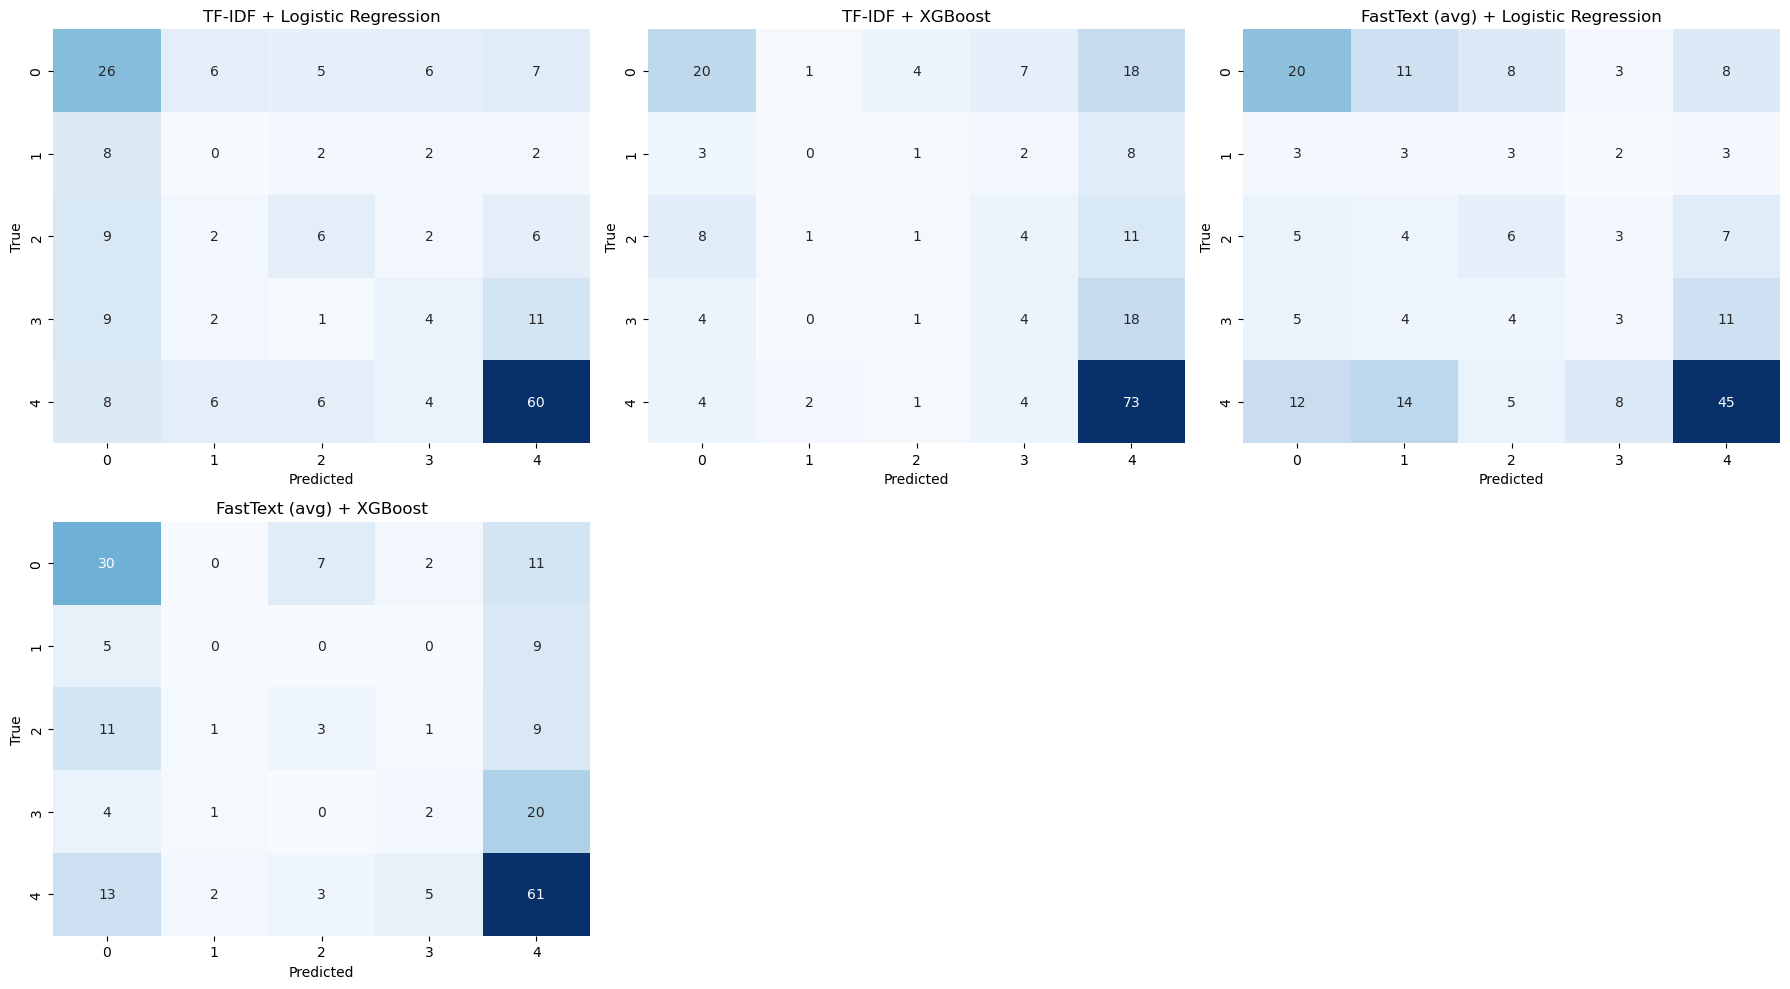

In [14]:
# --- Confusion Matrices ---
preds = [
    (pred_TF_LR_ft, y_test, "TF-IDF + Logistic Regression"),
    (pred_TF_XGB_ft, y_test, "TF-IDF + XGBoost"),
    (pred_FT_LR_ft, y_test_FT, "FastText (avg) + Logistic Regression"),
    (pred_FT_XGB_ft, y_test_FT, "FastText (avg) + XGBoost"),
]

# Determine number of classes automatically
num_classes = len(np.unique(y_test))
class_labels = [str(i) for i in range(num_classes)]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (pred, y_true, title) in enumerate(preds):
    if i >= len(axes):  # safety check if fewer than 6 subplots
        break
    cm = confusion_matrix(y_true, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
    axes[i].set_title(title)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

# Hide extra subplot if any
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()